## Import libraries and read data 

In [1]:
# OS path
from pathlib import Path

# Data and plot
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import StandardScaler

# RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, AllChem 
from rdkit.Chem import PandasTools, rdDepictor, rdFMCS
from rdkit.ML.Cluster import Butina
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image

Load fragments from FDA approved drugs:

In [2]:
HERE = Path(_dh[-1])
DATA_FOLDER = HERE.parent.parent/'data'

fda_ring_fragments = pd.read_csv(DATA_FOLDER/'fragments/unique/drug_fragments_no_duplicated.csv')
fda_ring_fragments.head(3)

,parent_smiles,ring_fragment,chembl_id
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308
1,C1CNCCN1,C1CNCCN1,CHEMBL1412
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348


Load FDA approved drugs dataset:

In [3]:
fda_drugs = pd.read_csv(DATA_FOLDER/'fda_approved_datasets/fda_approved_drugs.csv')
fda_drugs[['chembl_id', 'oral']].head(3)

,chembl_id,oral
0,CHEMBL1200728,True
1,CHEMBL734,True
2,CHEMBL467,True


Merge dosage form information with Ring Fragments Generated:

In [4]:
# merging info about dosage_form
ring_fragments_dosage_form = pd.merge(fda_ring_fragments, fda_drugs[['chembl_id', 'oral']], on='chembl_id', how='left')
print(ring_fragments_dosage_form.shape)
ring_fragments_dosage_form.head(3)

(3590, 4)


,parent_smiles,ring_fragment,chembl_id,oral
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308,False
1,C1CNCCN1,C1CNCCN1,CHEMBL1412,True
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348,True


### Separate oral/non-oral fragments

In [5]:
ring_fragments_oral = ring_fragments_dosage_form[ring_fragments_dosage_form['oral'] == True]
ring_fragments_oral

,parent_smiles,ring_fragment,chembl_id,oral
1,C1CNCCN1,C1CNCCN1,CHEMBL1412,True
2,Nc1ccncc1,Nc1ccncc1,CHEMBL284348,True
3,N[C@@H]1CONC1=O,N[C@@H]1CONC1=O,CHEMBL771,True
4,Nc1ccncc1N,Nc1ccncc1N,CHEMBL354077,True
8,Cn1ccnc1S,Cn1ccnc1S,CHEMBL1515,True
...,...,...,...,...
3562,CN1Cc2c(Cl)cc(Cl)cc2[C@H](c2cccc(S(=O)(=O)NCCO...,C[C@@H]1CN(C)Cc2c(Cl)cc(Cl)cc21,CHEMBL3304485,True
3563,CN1Cc2c(Cl)cc(Cl)cc2[C@H](c2cccc(S(=O)(=O)NCCO...,Cc1cccc(S)c1,CHEMBL3304485,True
3582,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,CHEMBL262777,True
3583,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,C[C@@H]1O[C@@H](O)C[C@](C)(N)[C@@H]1O,CHEMBL262777,True


In [6]:
ring_fragments_non_oral = ring_fragments_dosage_form[ring_fragments_dosage_form['oral'] == False]
ring_fragments_non_oral

,parent_smiles,ring_fragment,chembl_id,oral
0,Cc1cn[nH]c1,Cc1cn[nH]c1,CHEMBL1308,False
5,Oc1cccc(O)c1,Oc1cccc(O)c1,CHEMBL24147,False
6,NCCc1cc[nH]n1,Cc1cc[nH]n1,CHEMBL1201323,False
7,NCCc1c[nH]cn1,Cc1c[nH]cn1,CHEMBL90,False
10,COc1ccc(O)cc1,Oc1ccc(O)cc1,CHEMBL544,False
...,...,...,...,...
3585,CCC(C)CCCCC(=O)NC(CCNCS(=O)(=O)O)C(=O)NC(C(=O)...,CC1NC(=O)C(N)CCNC(=O)C(C)NC(=O)C(C)NC(=O)C(C)N...,CHEMBL1201441,False
3586,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@@H]1O[C@@H](O)C[C@](C)(N)[C@@H]1O,CHEMBL507870,False
3587,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O,CHEMBL507870,False
3588,CCCCCCCCCCNCCN[C@@]1(C)C[C@H](O[C@H]2[C@H](Oc3...,Cc1c(O)cc2c(c1O)-c1cc(ccc1O)[C@H]1NC(=O)[C@@H]...,CHEMBL507870,False


In [7]:
print(f'There are {ring_fragments_oral.shape[0]} oral fragments and\n {ring_fragments_non_oral.shape[0]} non oral fragments')

There are 2353 oral fragments and
 1237 non oral fragments


We can store the information into a list of tuples to make the code run significantly faster.

In [8]:
oral_rfs = []
non_oral_rfs = []

for _, ring_fragment, chembl_id in ring_fragments_oral[['ring_fragment', 'chembl_id']].itertuples():
    oral_rfs.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

for _, ring_fragment, chembl_id in ring_fragments_non_oral[['ring_fragment', 'chembl_id']].itertuples():
    non_oral_rfs.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

print(f"Number of oral ring fragments inserted into the list: {len(oral_rfs)}\nNumber of non oral ring fragments inserted into its list: {len(non_oral_rfs)}")

Number of oral ring fragments inserted into the list: 2353
Number of non oral ring fragments inserted into its list: 1237


### Basic stats

In [9]:
from collections import Counter

# Count the number of rings for oran vs non-oral rfs
oral_ring_counts = [rdMolDescriptors.CalcNumRings(rf) for rf, _ in oral_rfs]
non_oral_ring_counts = [rdMolDescriptors.CalcNumRings(rf) for rf, _ in non_oral_rfs]

print(f"Oral fragments by ring size: {Counter(oral_ring_counts)} Total: {sum(Counter(oral_ring_counts).values())} \nNon-Oral fragments by ring size: {Counter(non_oral_ring_counts)} Total: {sum(Counter(non_oral_rfs).values())}")

Oral fragments by ring size: Counter({1: 1682, 2: 406, 3: 121, 4: 103, 5: 36, 6: 2, 8: 1, 7: 1, 10: 1}) Total: 2353 
Non-Oral fragments by ring size: Counter({1: 830, 2: 187, 4: 119, 3: 63, 5: 28, 7: 4, 8: 2, 10: 2, 11: 1, 6: 1}) Total: 1237


#### Plot basic stats

A visual identification of the information is a very good practice analysing data.

[0.0, 1766.1, 0.0, 1766.1]

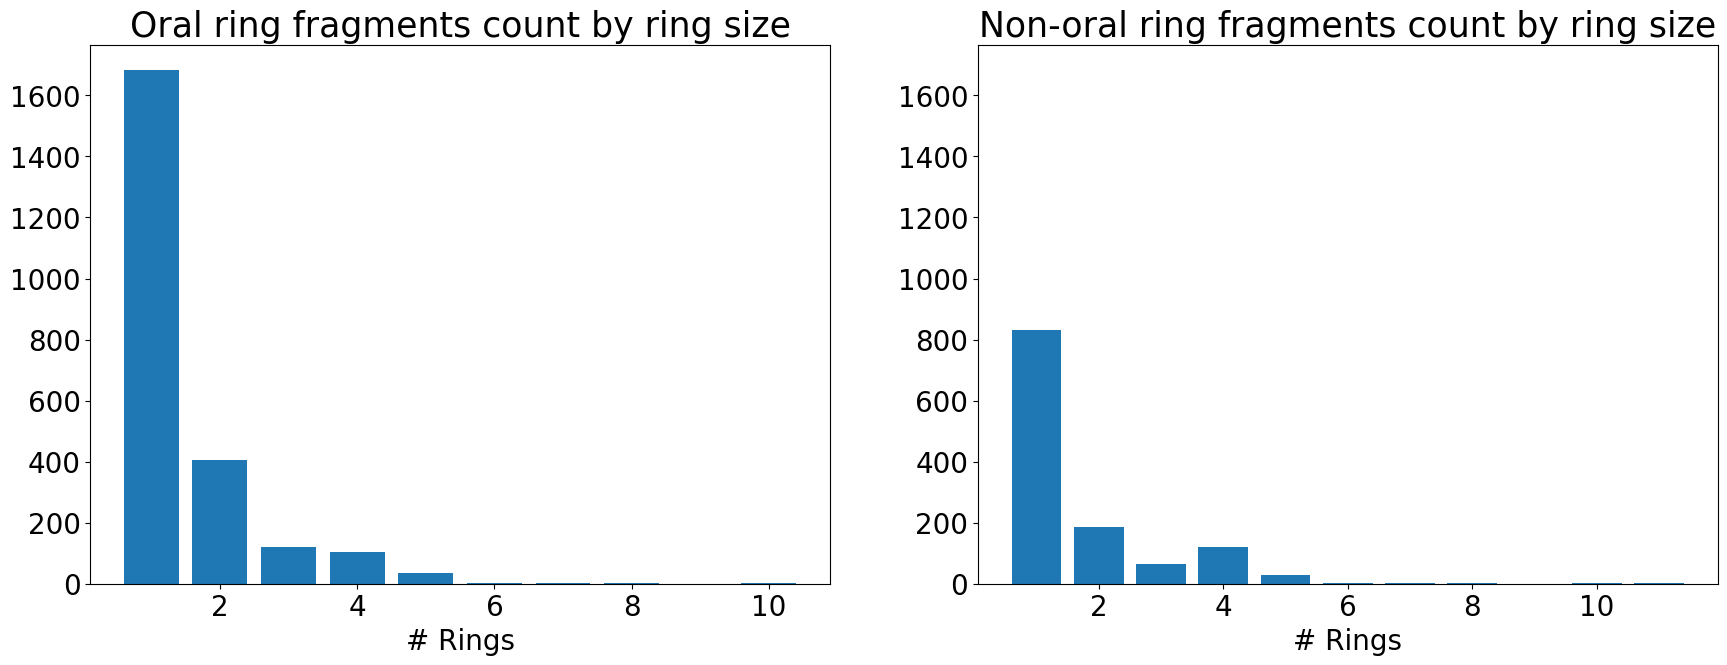

In [10]:
fig, ax = plt.subplots(1,2, figsize=(21,7))
TITLE_FONT_SIZE = 25
AXIS_FONT_SIZE = 20
TICKS_SIZE = 20

titles = [
    'Oral ring fragments count by ring size',
    'Non-oral ring fragments count by ring size'
]

data = [
    Counter(oral_ring_counts),
    Counter(non_oral_ring_counts)
]

for i in range(2):
    ax[i].bar(data[i].keys(), data[i].values())
    ax[i].set_title(titles[i], fontsize=TITLE_FONT_SIZE)
    ax[i].set_xlabel("# Rings", fontsize=AXIS_FONT_SIZE)
    ax[i].tick_params(axis='both', which='major', labelsize=TICKS_SIZE)

# Final adjustments
plt.setp(ax, ylim=ax[0].get_ylim())

## Compute fingerprints, tanimoto sim and dist matrix

### Oral)

#### 1) Compute fingerprints

In [11]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
oral_fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in oral_rfs]

print(f"Number of fp computed: {len(oral_fingerprints)}\
    \nFingerprint length per compound: {len(oral_fingerprints[0])}\
    \nNumber of ring fragments derived from oral compounds: {len(oral_rfs)}")

Number of fp computed: 2353    
Fingerprint length per compound: 2048    
Number of ring fragments derived from oral compounds: 2353


In [12]:
# Example of a fingerprint object inside ou list of fingerprints (i.e. oral_fingerprint)
np.array(oral_fingerprints[0])

array([0, 0, 0, ..., 0, 0, 1])

#### 2) Tanimoto similarity and distance matrix

Helper function to compute the tanimoto distance matrix:

In [13]:
def tanimoto_distance_matrix(fp_list:list) -> list:
    dissimilarity_matrix = []

    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])

    return dissimilarity_matrix

In [14]:
n = len(oral_fingerprints)
elem_triangular_matrix = ( (n*(n-1)) / 2)

print(f"Elements in the triagular matrix = {elem_triangular_matrix} must be equal to\
    \n tanimoto_distance_matrix(oral_fingerprints) = {len(tanimoto_distance_matrix(oral_fingerprints))}")

Elements in the triagular matrix = 2767128.0 must be equal to    
 tanimoto_distance_matrix(oral_fingerprints) = 2767128


Everything seems good so far.

#### 3) Cluster, select threshold

In [15]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    
    distance_matrix = tanimoto_distance_matrix(fingerprints) # compute dist matrix

    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)

    return clusters

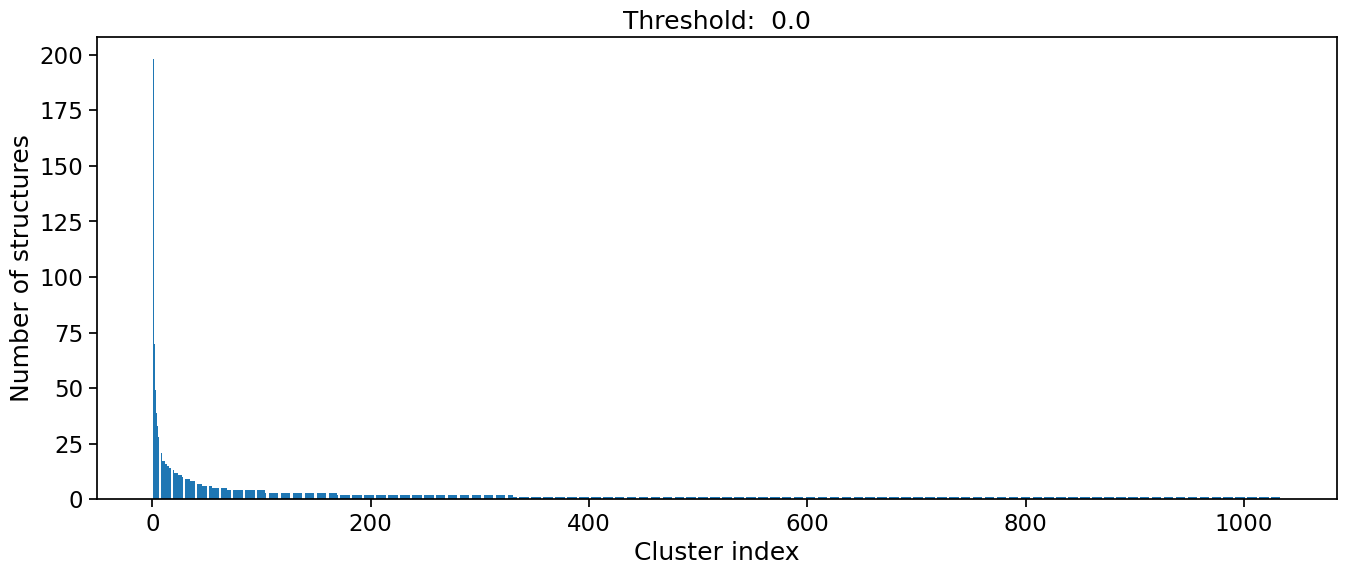

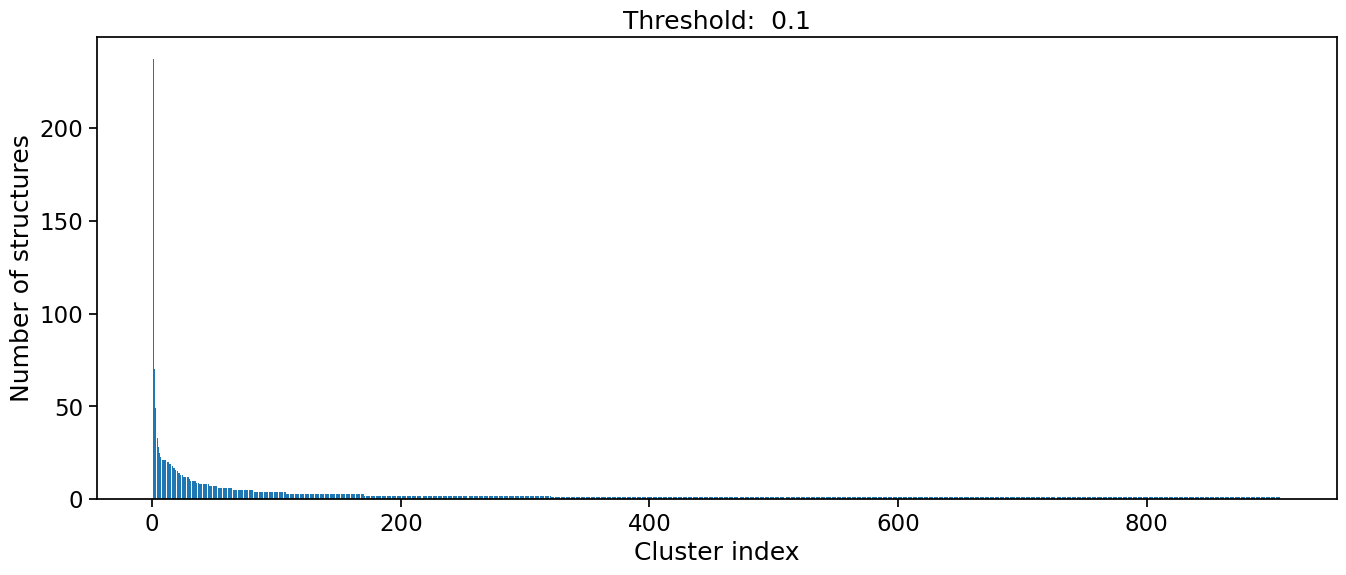

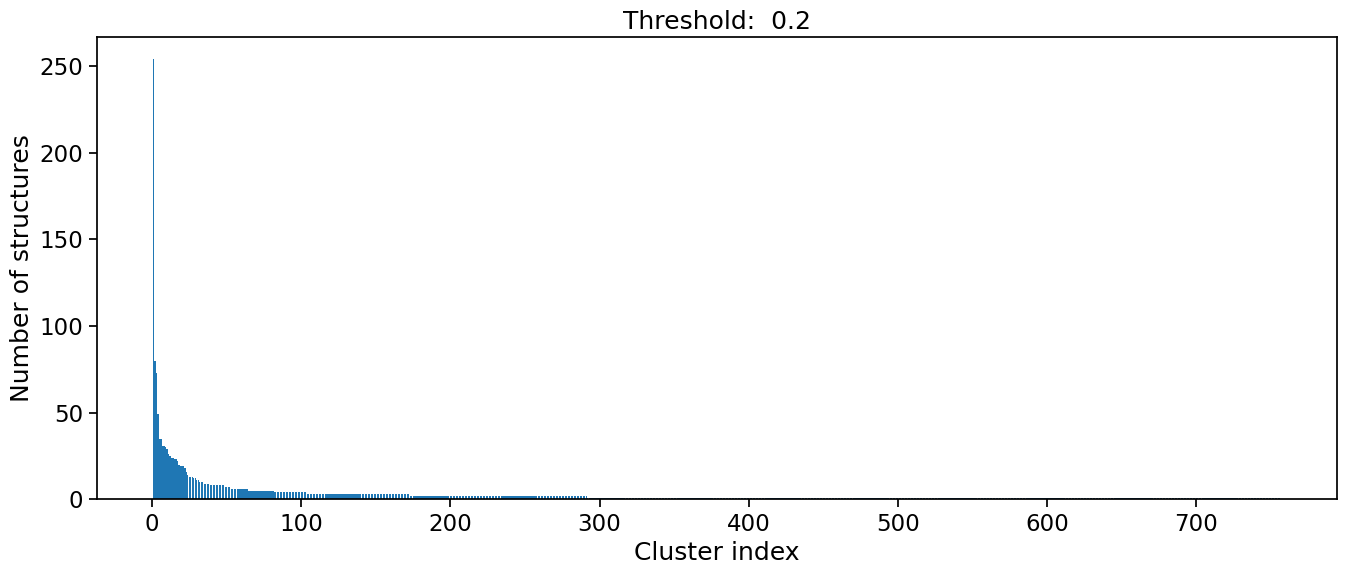

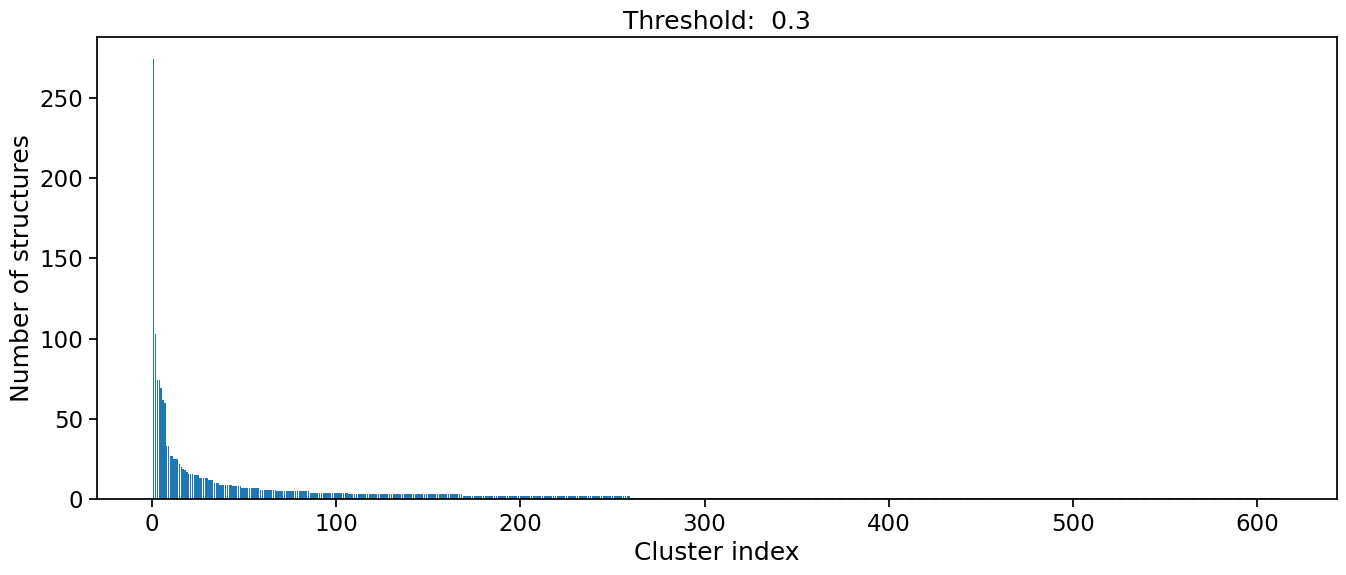

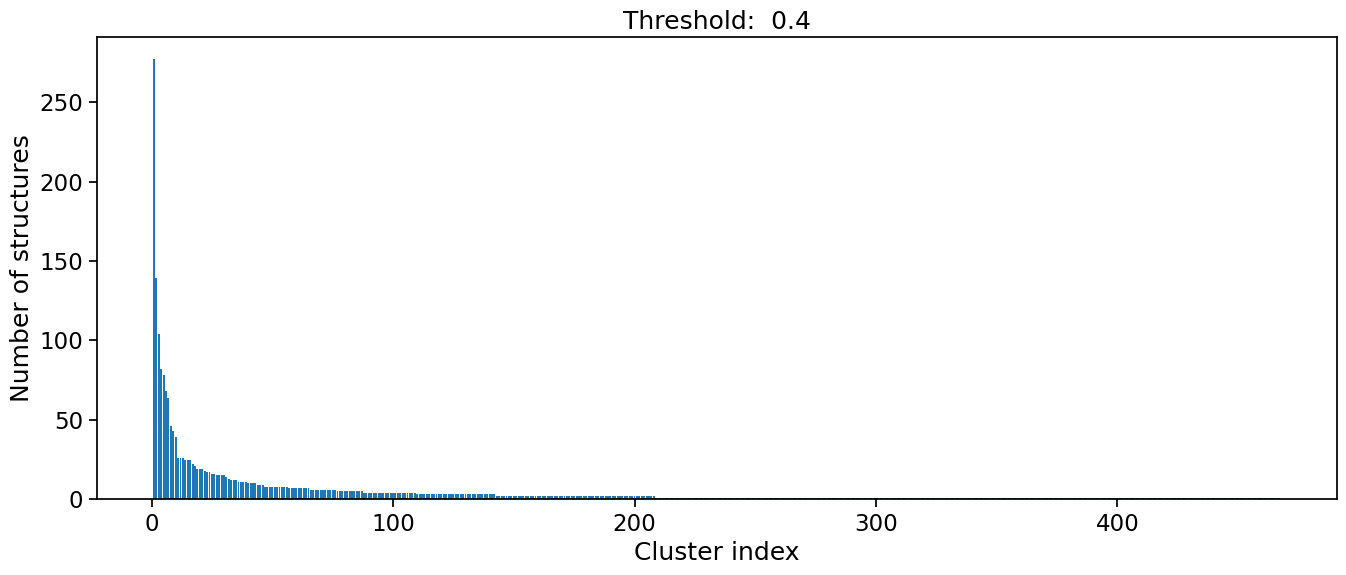

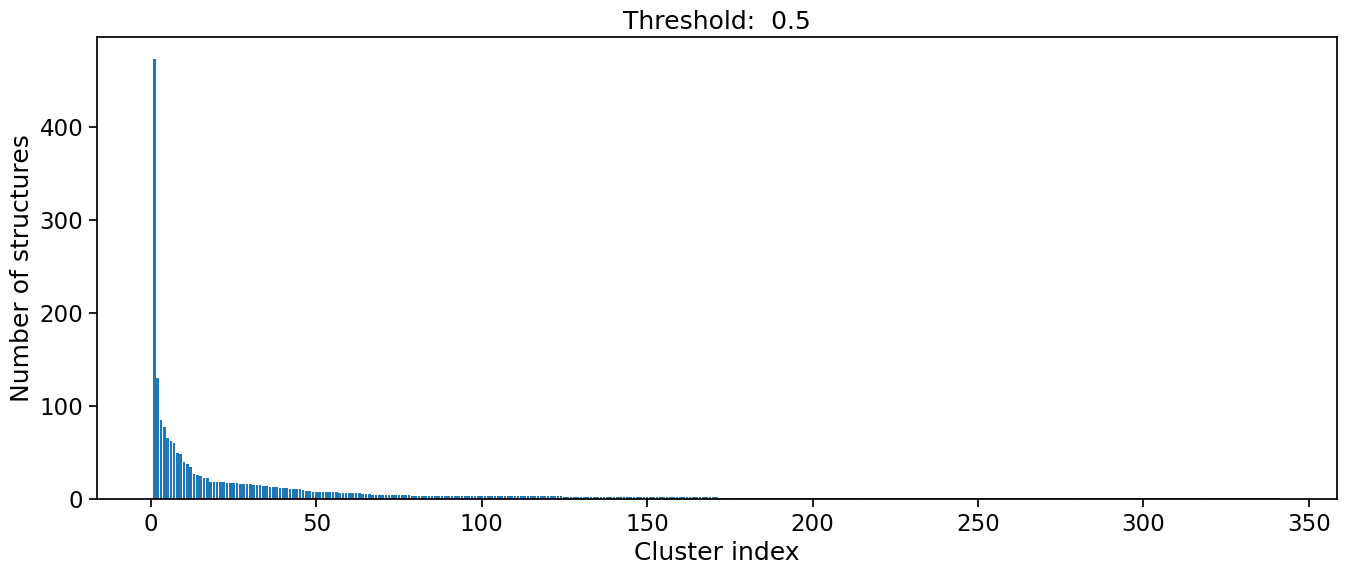

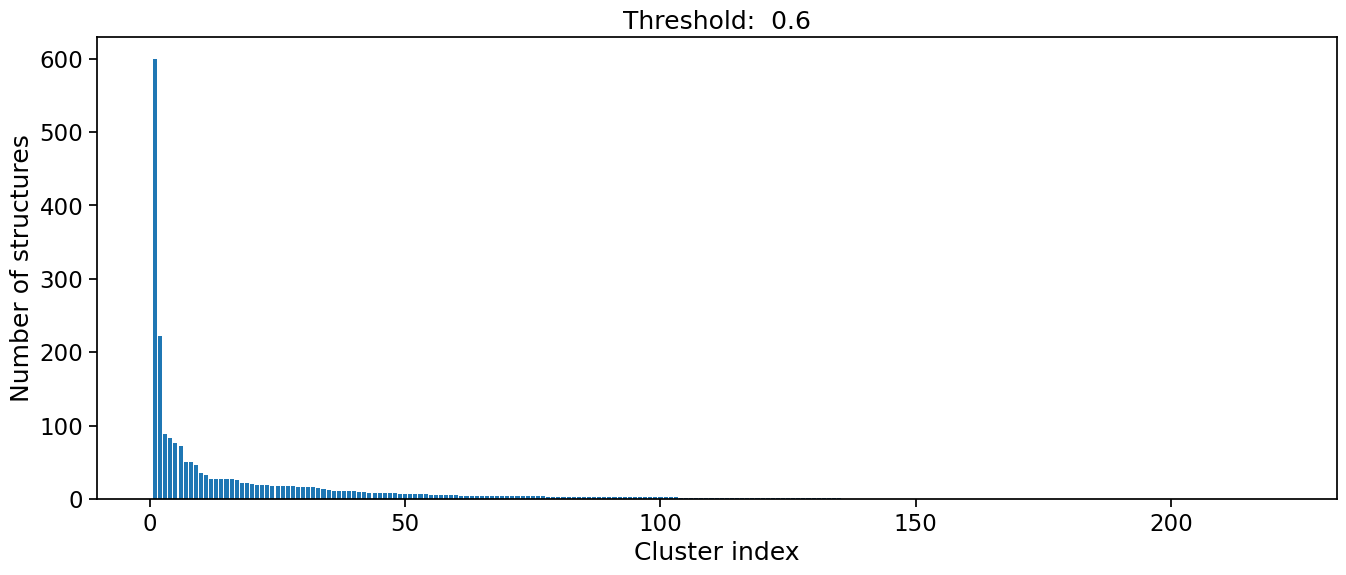

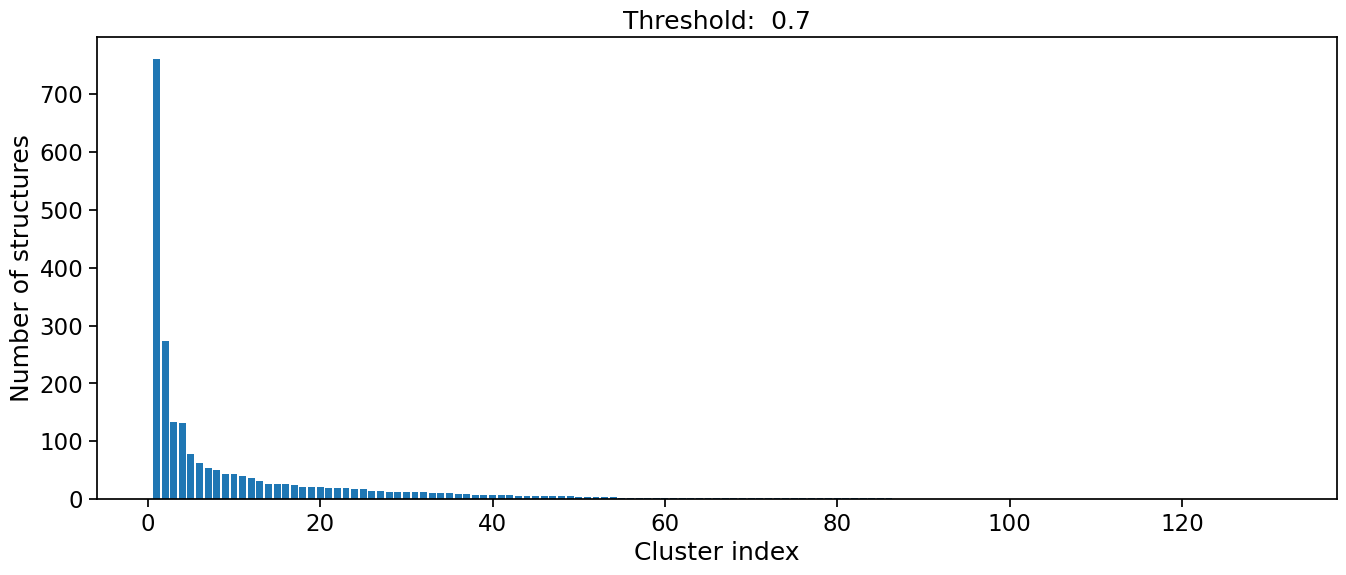

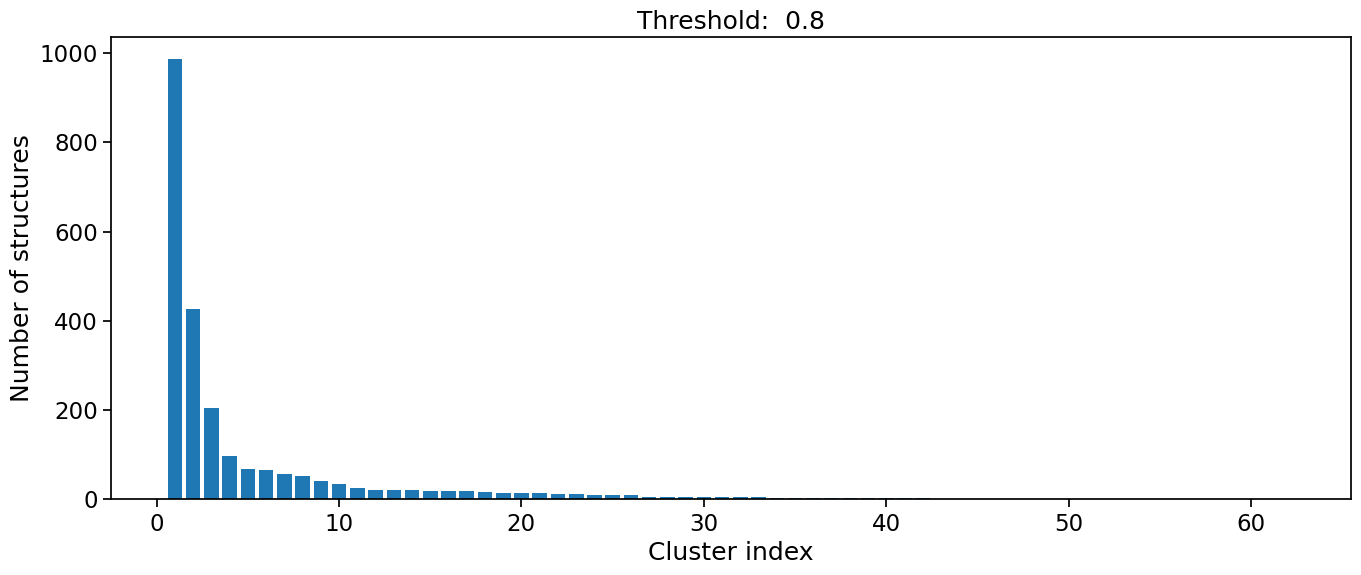

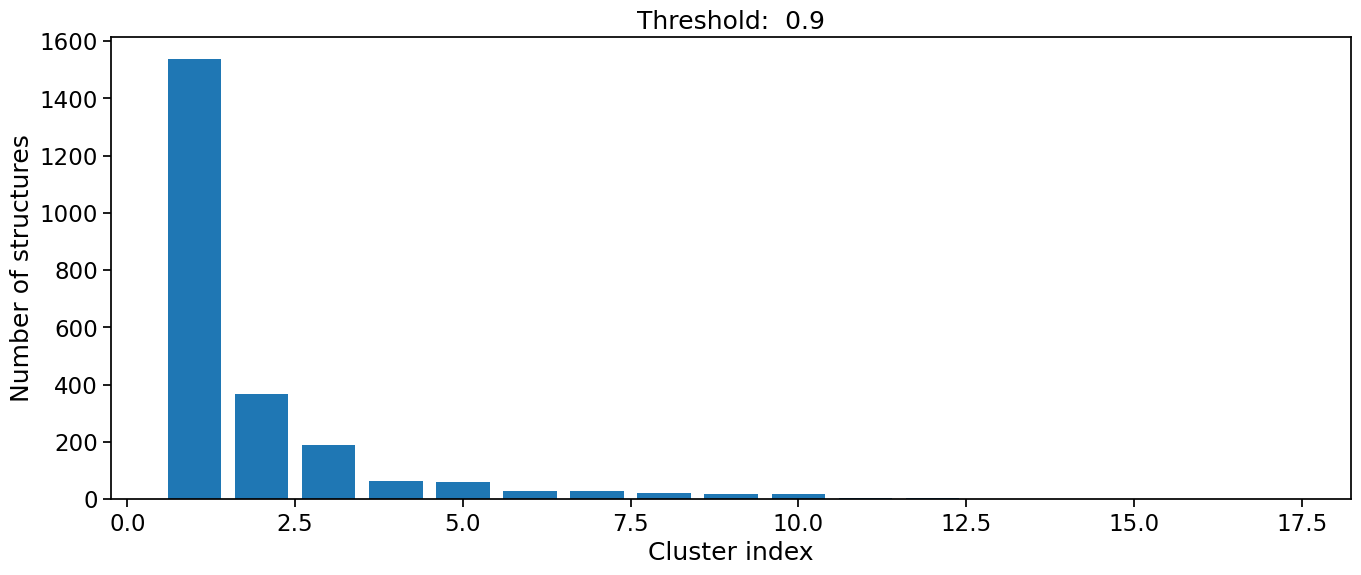

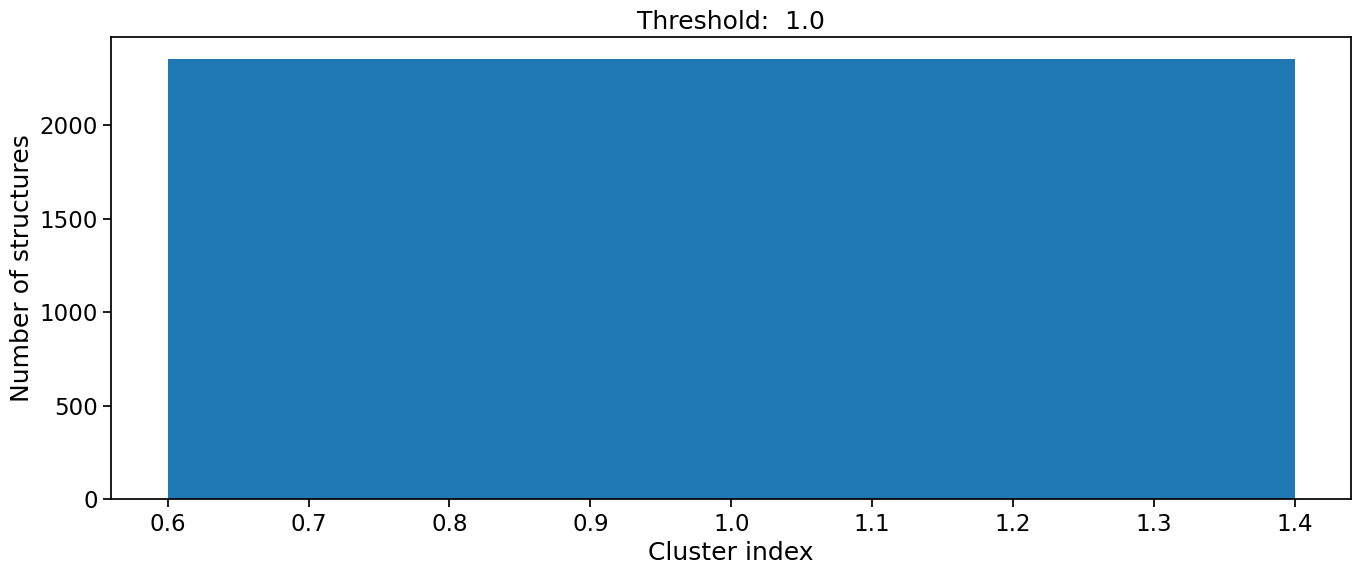

In [16]:
sns.set_context('notebook', font_scale=1.5)
cutoffs = np.arange(0.0, 1.1, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=oral_fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.1')

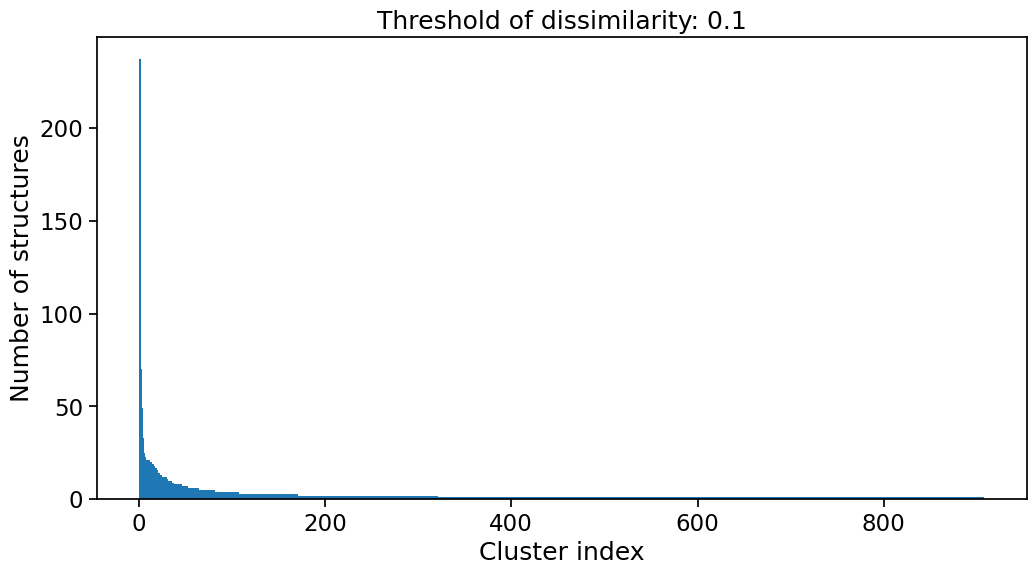

In [17]:
# Final selction of threshold
cutoff = 0.1
oral_clusters = cluster_fingerprints(oral_fingerprints, cutoff=0.1)

#plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(oral_clusters) + 1), [len(c) for c in oral_clusters], width=2)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')

In [18]:
print(
    f"Number of clusters: {len(oral_clusters)} from {len(oral_rfs)} ring fragments",
    f"\n Number of RF in the first 10 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 50 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,50)])}",
    f"\n Number of RF in the first 100 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 907 from 2353 ring fragments 
 Number of RF in the first 10 oral_clusters: 528 
 Number of RF in the first 20 oral_clusters: 710 
 Number of RF in the first 50 oral_clusters: 1002 
 Number of RF in the first 100 oral_clusters: 1249 


### Non-oral)

#### 1) Compute fingerprints

In [19]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
non_oral_fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in non_oral_rfs]

print(f"Number of fp computed: {len(non_oral_fingerprints)}\
    \nFingerprint length per compound: {len(non_oral_fingerprints[0])}\
    \nNumber of ring fragments derived from oral compounds: {len(non_oral_rfs)}")

Number of fp computed: 1237    
Fingerprint length per compound: 2048    
Number of ring fragments derived from oral compounds: 1237


#### 2) Tanimoto similarity and distance matrix

In [20]:
n = len(non_oral_fingerprints)
elem_triangular_matrix = ( (n*(n-1)) / 2)

print(f"Elements in the triagular matrix = {elem_triangular_matrix} must be equal to\
    \n tanimoto_distance_matrix(oral_fingerprints) = {len(tanimoto_distance_matrix(non_oral_fingerprints))}")

Elements in the triagular matrix = 764466.0 must be equal to    
 tanimoto_distance_matrix(oral_fingerprints) = 764466


#### 3) Cluster, select threshold

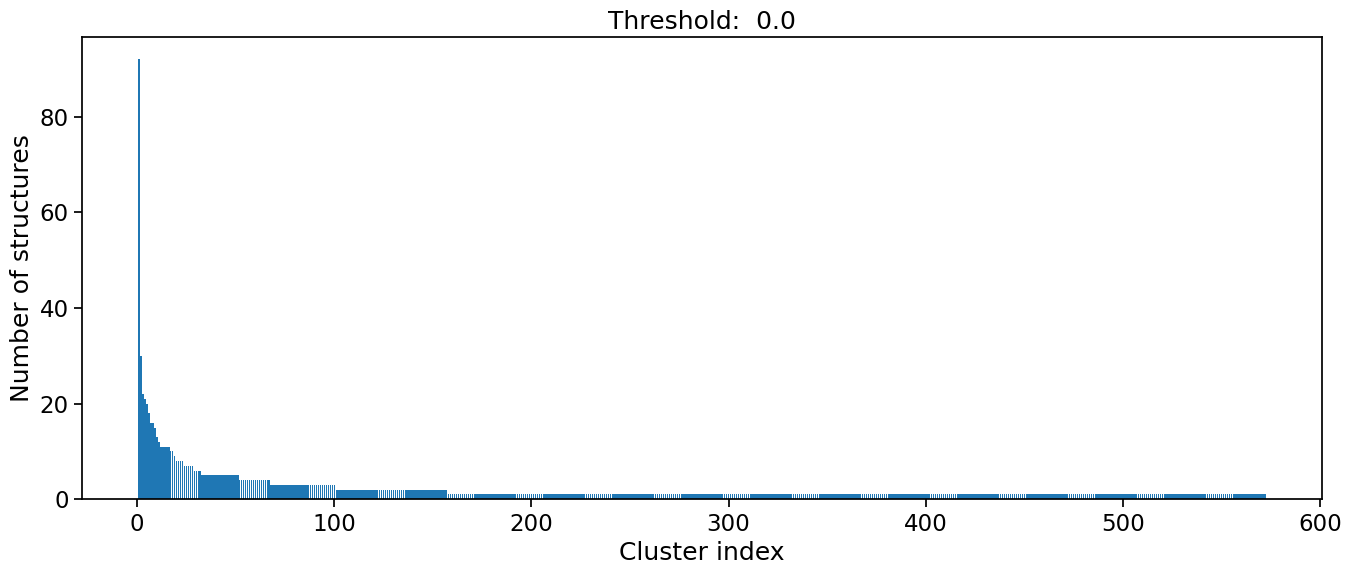

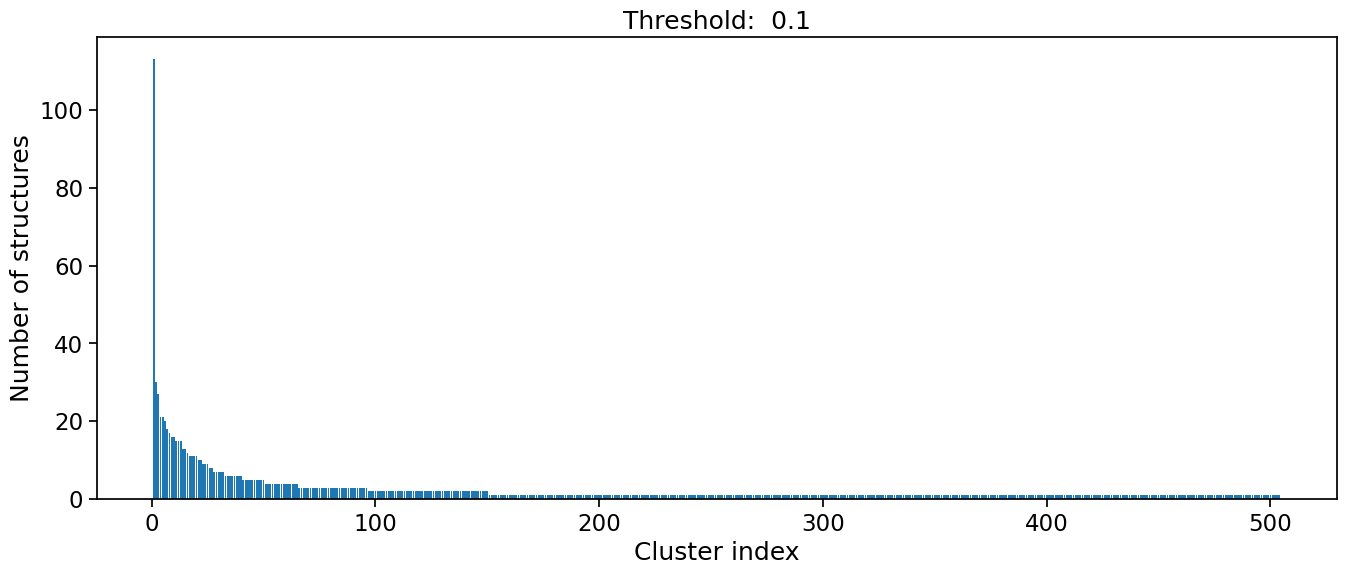

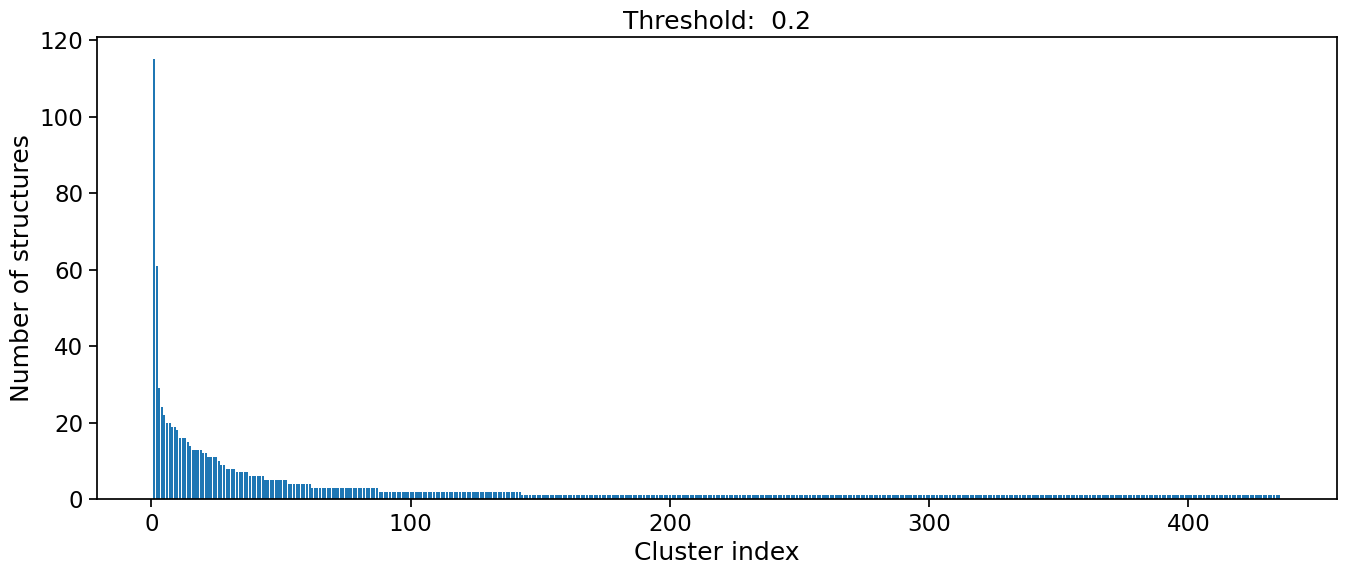

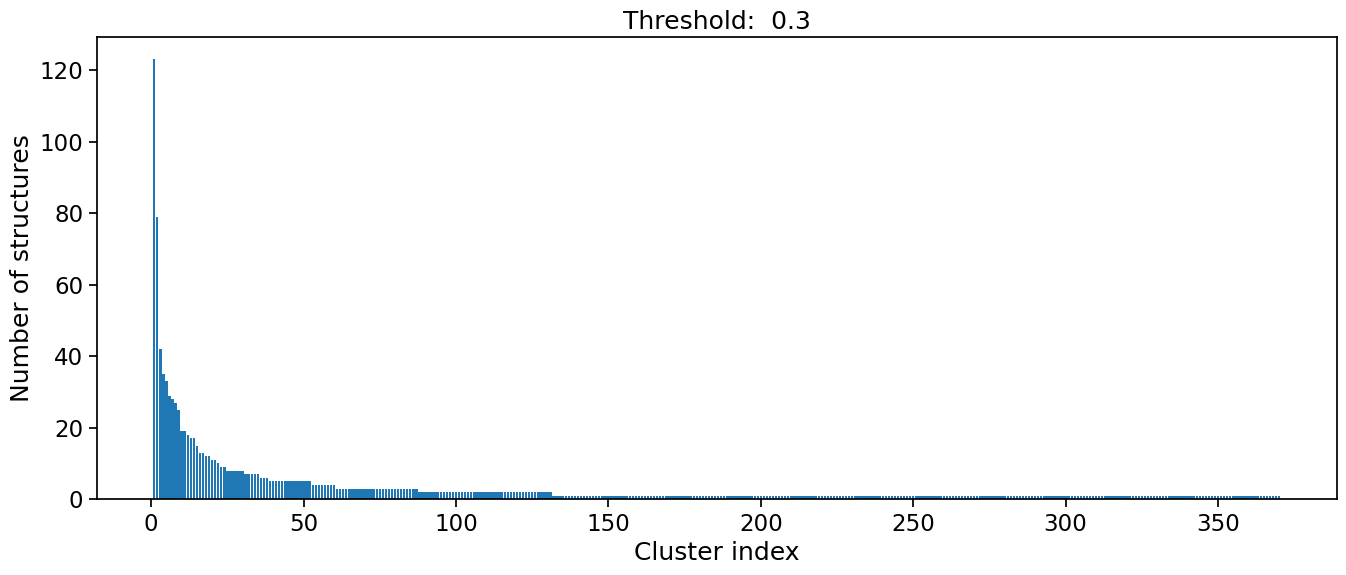

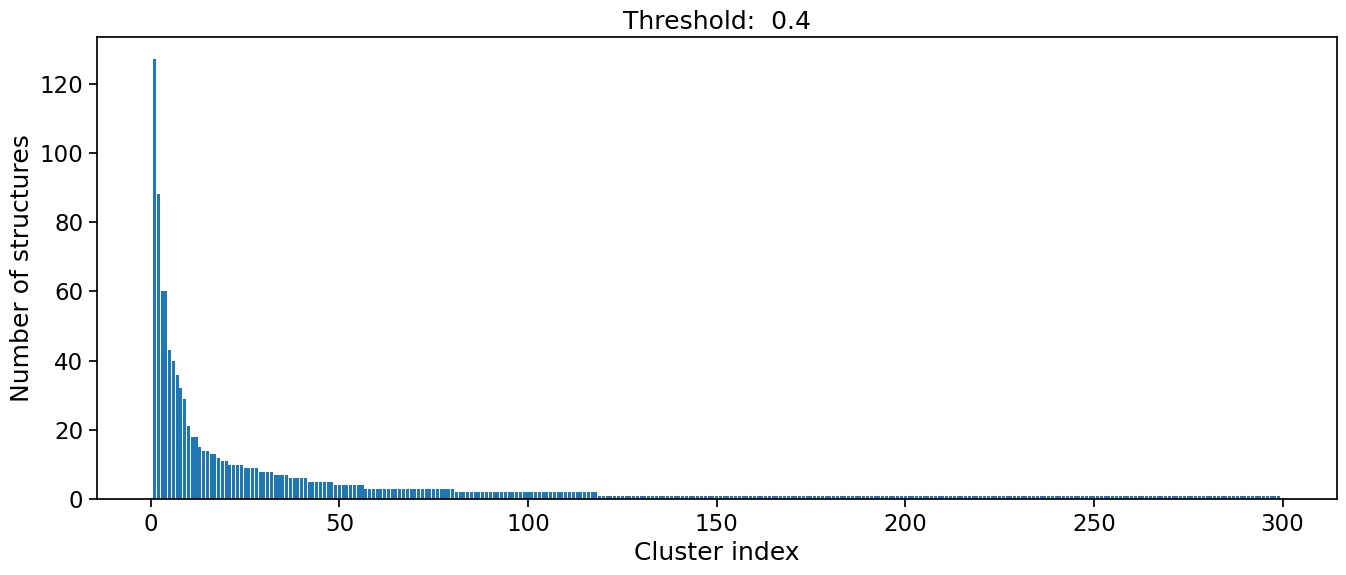

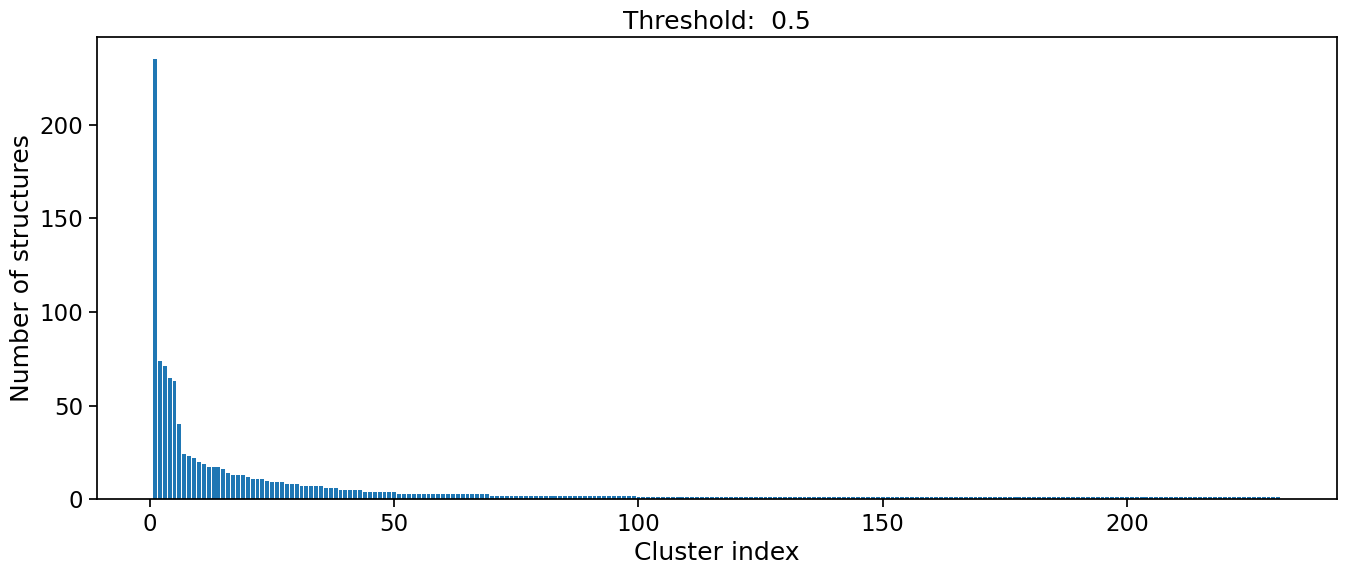

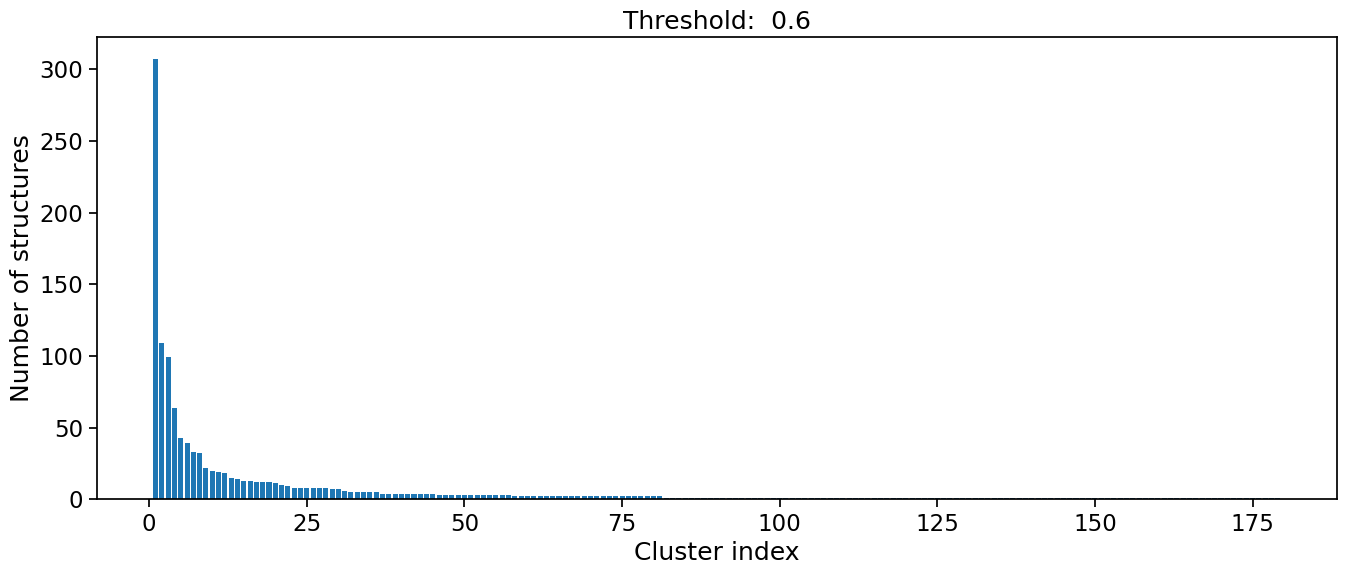

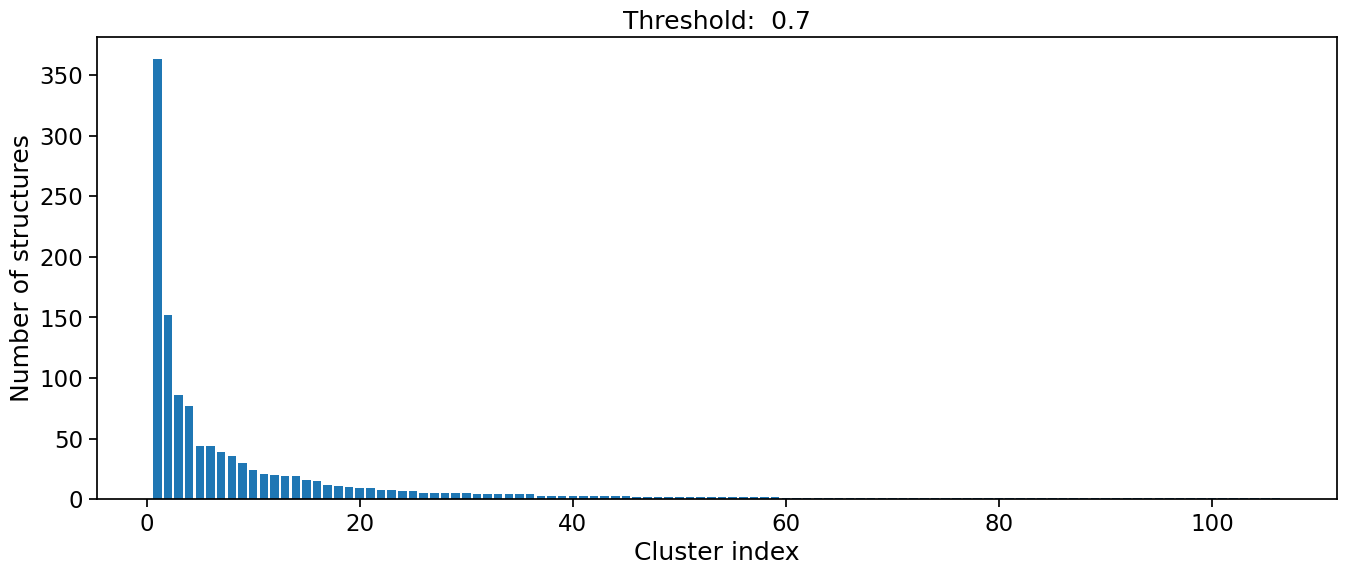

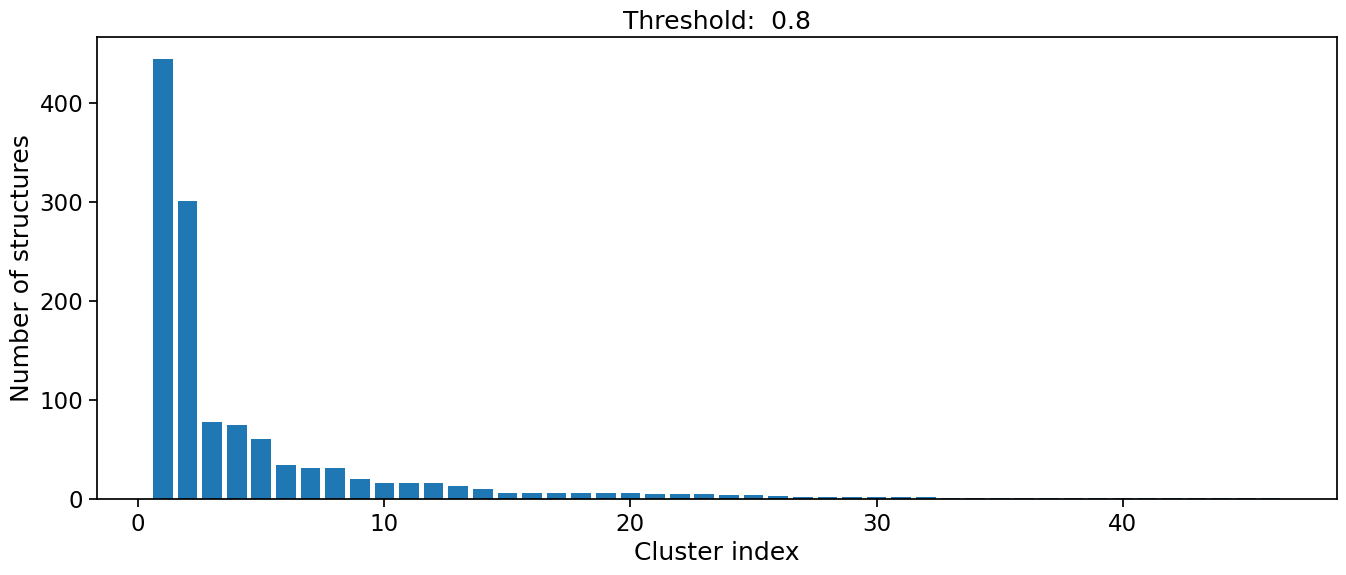

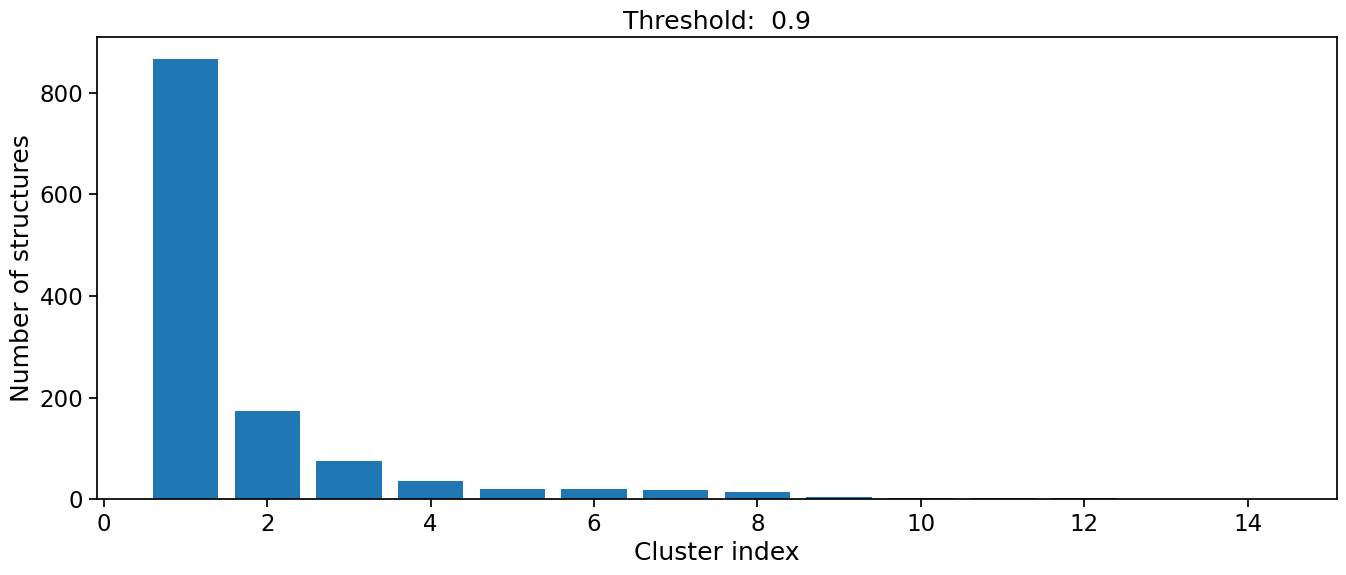

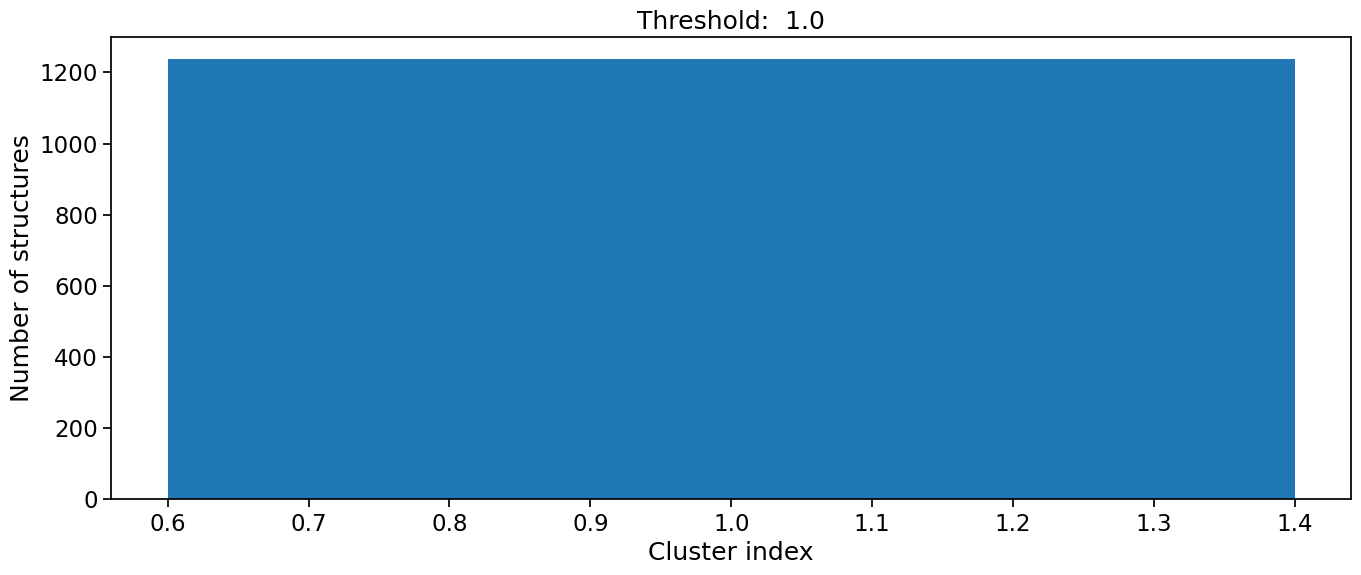

In [21]:
sns.set_context('notebook', font_scale=1.5)
cutoffs = np.arange(0.0, 1.1, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=non_oral_fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.1')

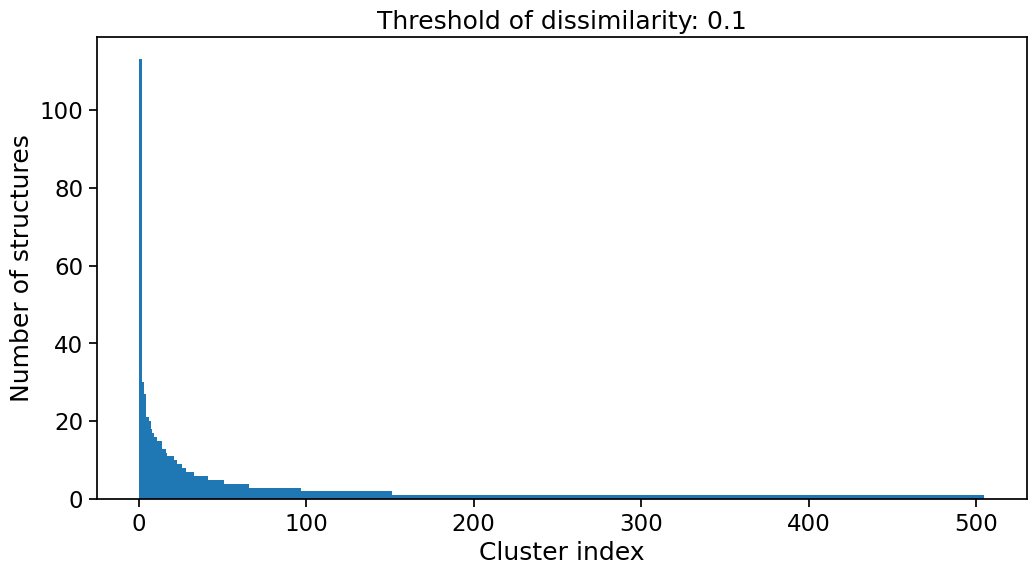

In [22]:
# Final selction of threshold
cutoff = 0.1
non_oral_clusters = cluster_fingerprints(non_oral_fingerprints, cutoff=0.1)

#plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(non_oral_clusters) + 1), [len(c) for c in non_oral_clusters], width=2)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')

In [23]:
print(
    f"Number of clusters: {len(non_oral_clusters)} from {len(non_oral_rfs)} ring fragments",
    f"\n Number of RF in the first 10 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 50 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,50)])}",
    f"\n Number of RF in the first 100 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 504 from 1237 ring fragments 
 Number of RF in the first 10 non_oral_clusters: 299 
 Number of RF in the first 20 non_oral_clusters: 426 
 Number of RF in the first 50 non_oral_clusters: 622 
 Number of RF in the first 100 non_oral_clusters: 783 


## Visualization

In [24]:
# Drawing options
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.fixedFontSize = 20
IPythonConsole.drawOptions.legendFraction = 0.2
IPythonConsole.drawOptions.legendFontSize = 23

In [25]:
# Helper function to draw top_n centroid clusters
def draw_top_n_centroids(n, clusters, compounds, molsPerRow):
    centroids = [cluster[0] for cluster in clusters[0:n]]
    mols = [compounds[c][0] for c in centroids]
   
    return Draw.MolsToGridImage(
        mols,
        legends= [f'f: {len(c)}' for c in clusters[0:n]],
        molsPerRow=molsPerRow,
        subImgSize=(300,240),
        maxMols=50
    )

In [28]:
## For each cluster, retrieve a maximum common substructure smarts
def get_clusters_mcs(clusters, mols):
    mcs_clusters = []
    for cluster in clusters:
        cluster_mols = [mols[idx][0] for idx in cluster]
        res = rdFMCS.FindMCS(cluster_mols)
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        mcs_clusters.append(mcs_mol)
    return mcs_clusters

### Oral)

#### Cluster Centroids

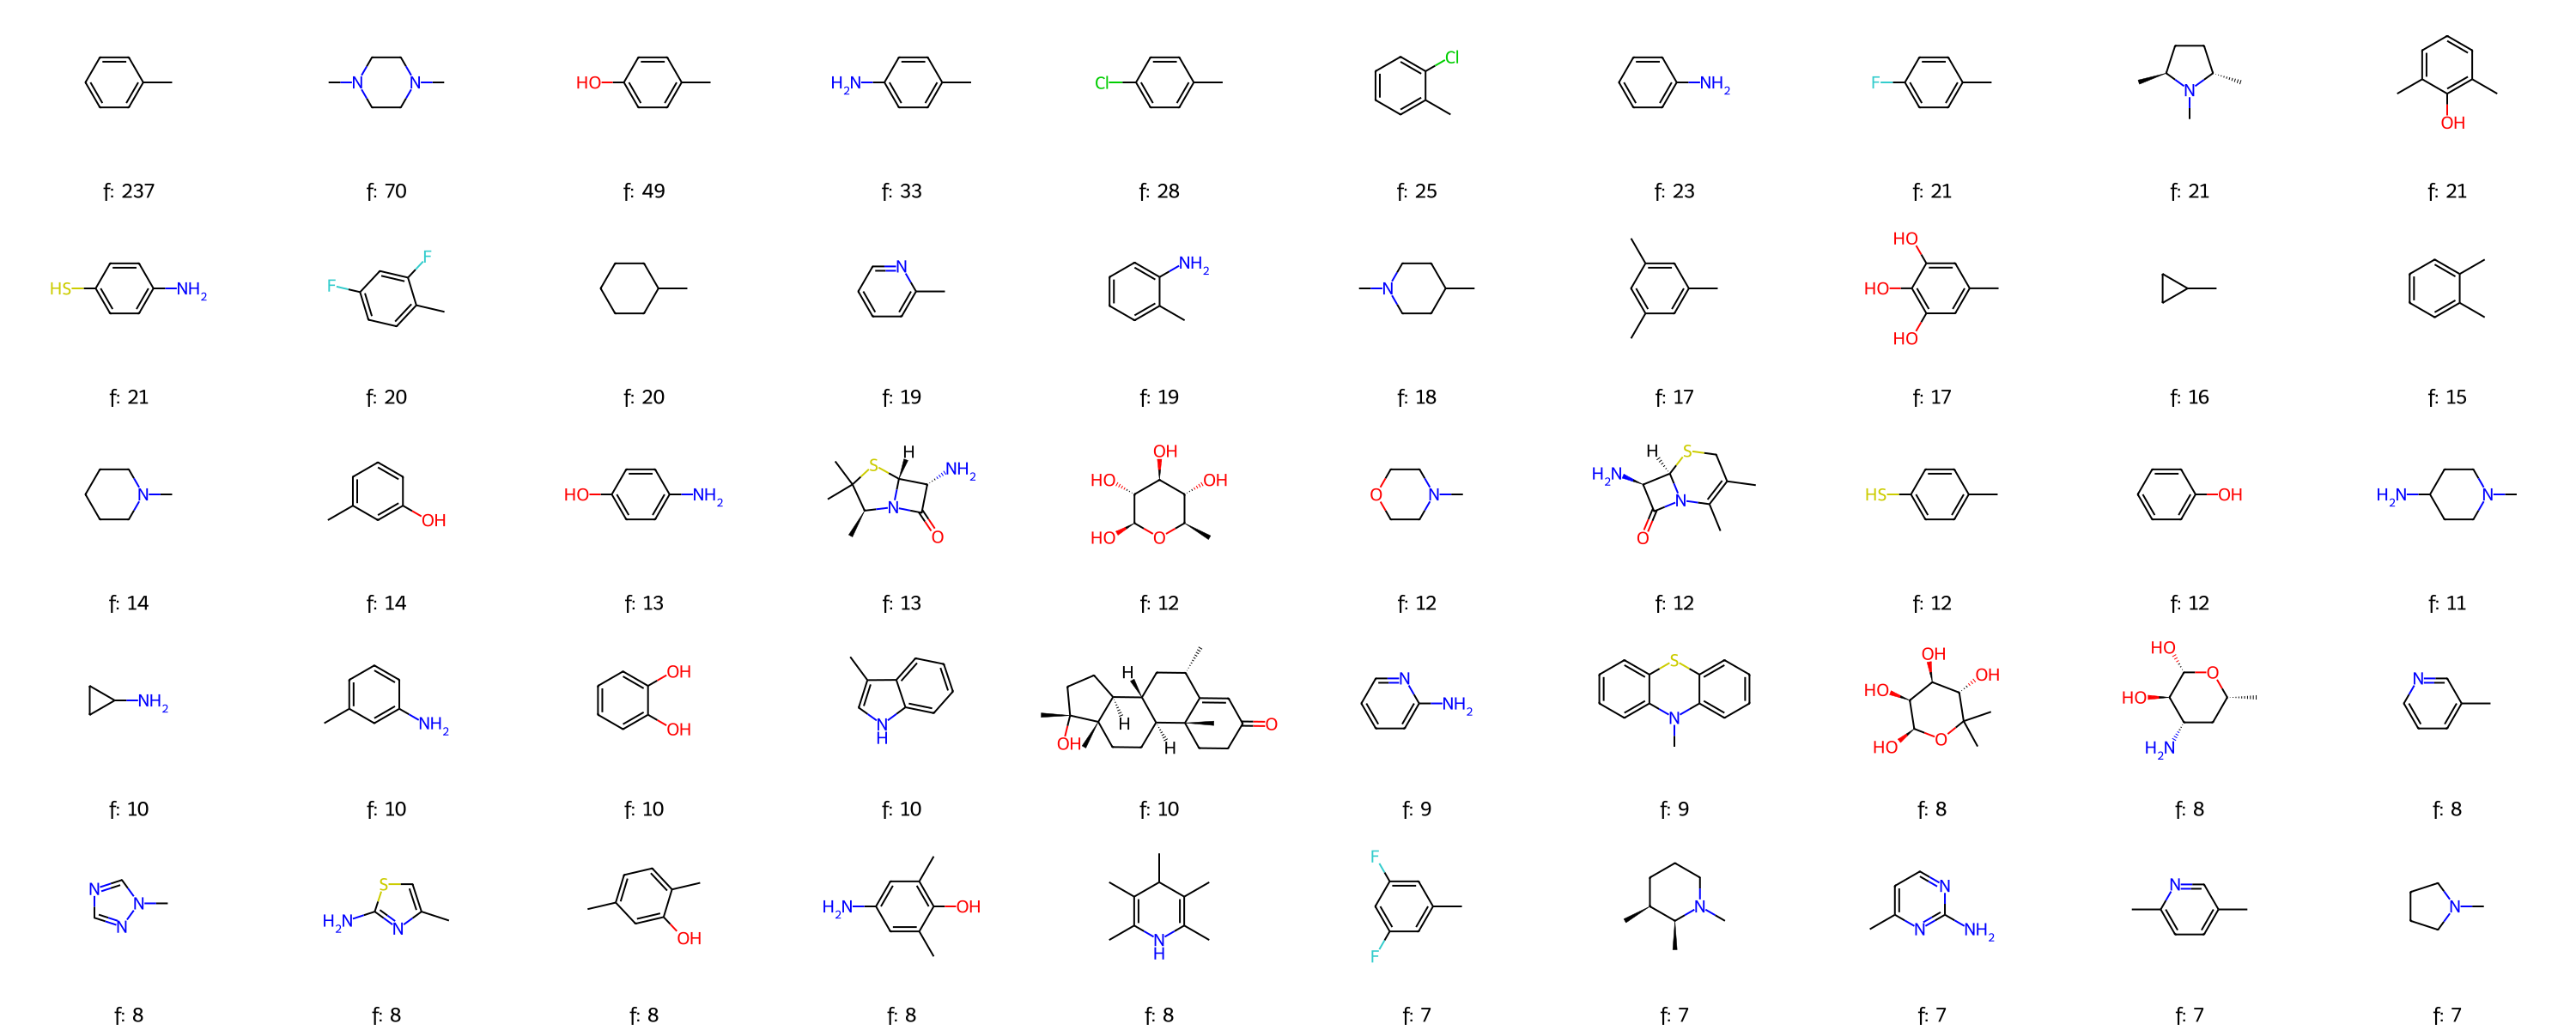

In [27]:
draw_top_n_centroids(100, oral_clusters, oral_rfs, molsPerRow=10)

#### Cluster centroids with highlight

In [30]:
oral_clusters_mcs_mols = get_clusters_mcs(clusters=oral_clusters[0:100], mols=oral_rfs)

# Getting mols of the first 100 oral_clusters centroids
oral_top_100_centroids = [cluster[0] for cluster in oral_clusters[0:100]]
oral_top_100_mol_centroids = [oral_rfs[i][0] for i in oral_top_100_centroids]
oral_legends_top_100_centroids = [f"n = {len(c)}" for c in oral_clusters[0:100]]

# Getting the matches
cluster_mcs_and_centroids = zip(oral_clusters_mcs_mols, oral_top_100_mol_centroids, oral_legends_top_100_centroids)
oral_matches = []
for mcs, centroid, _ in cluster_mcs_and_centroids:
    oral_matches.append(list(centroid.GetSubstructMatch(mcs)))

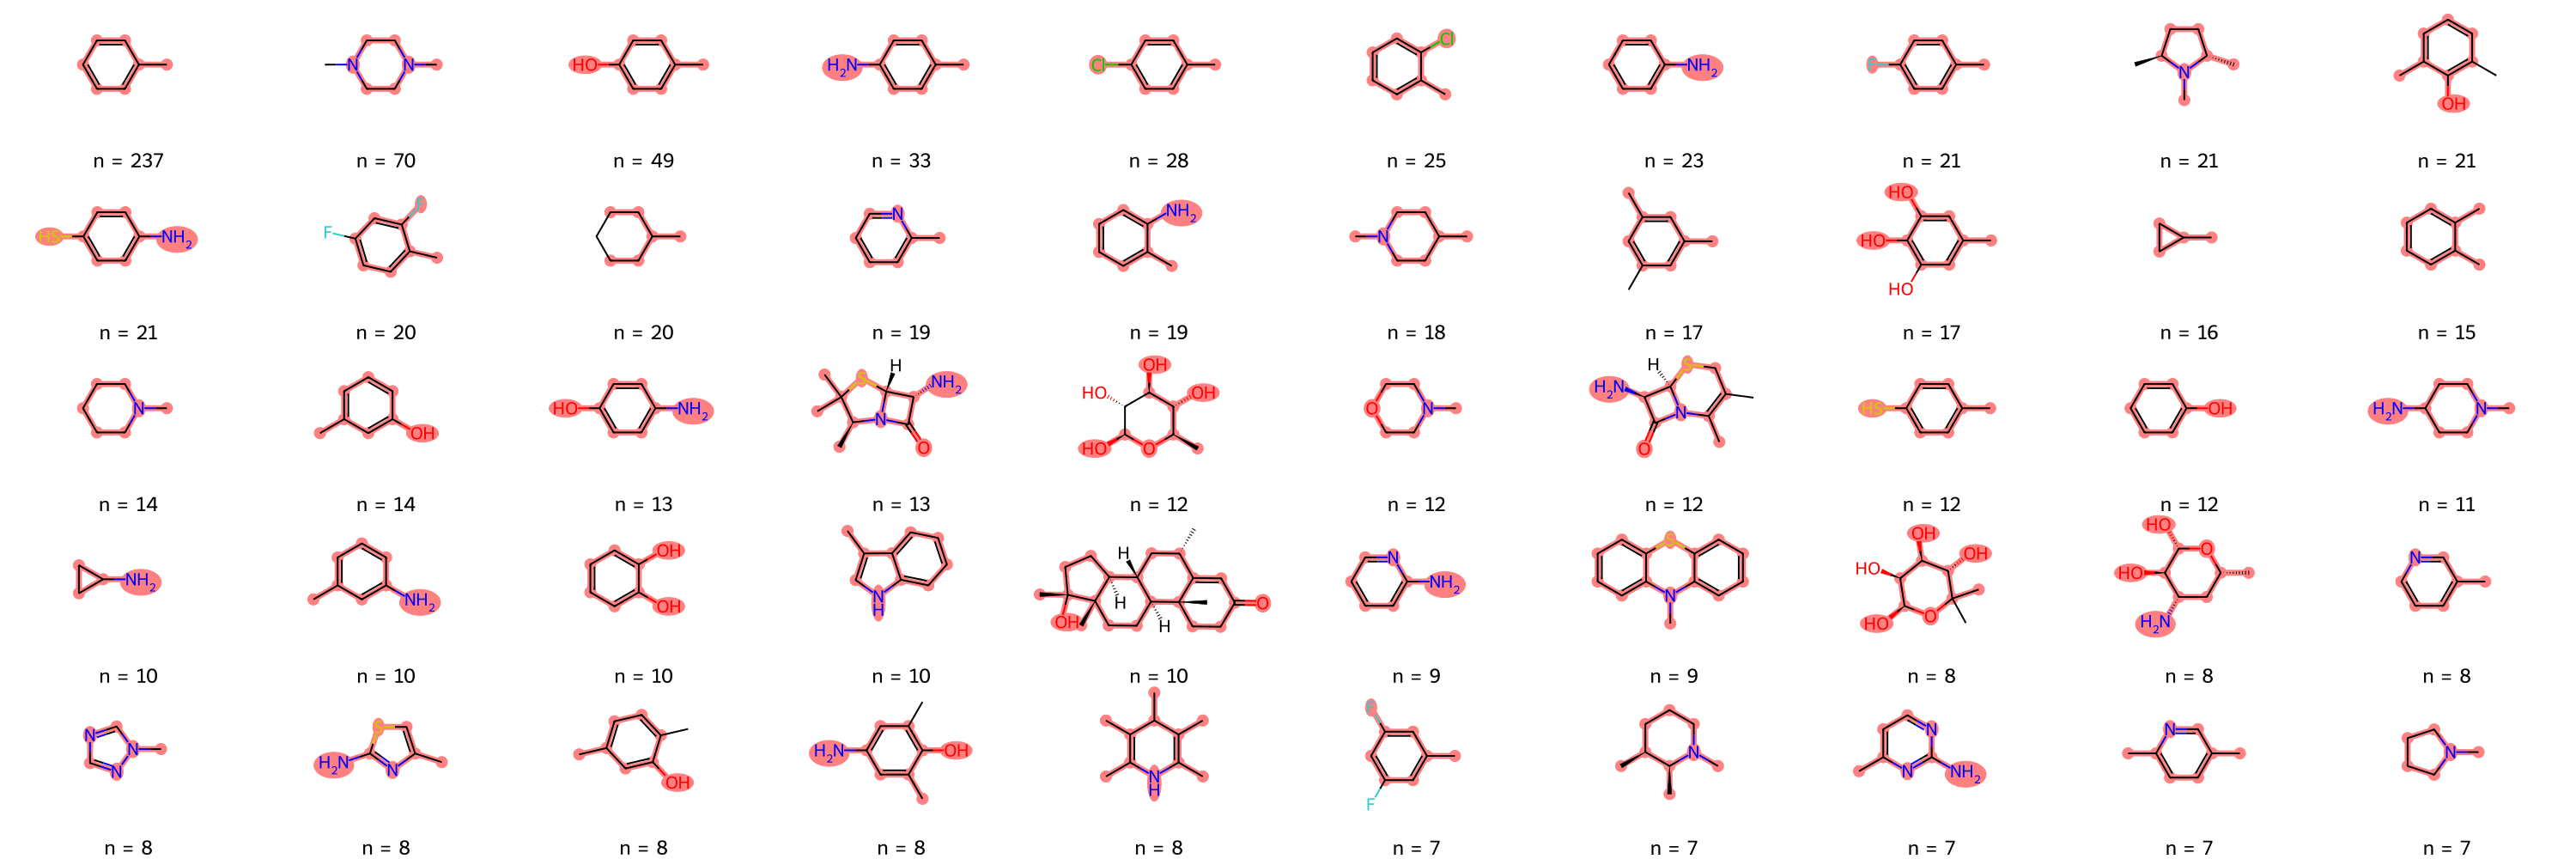

In [34]:
Draw.MolsToGridImage(
    oral_top_100_mol_centroids[0:50], 
    highlightAtomLists=oral_matches,
    legends=oral_legends_top_100_centroids[0:50],
    subImgSize=(300,200), 
    molsPerRow=10)

#### Grouped by ring size:

### Non-oral)

/home/gustavos/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


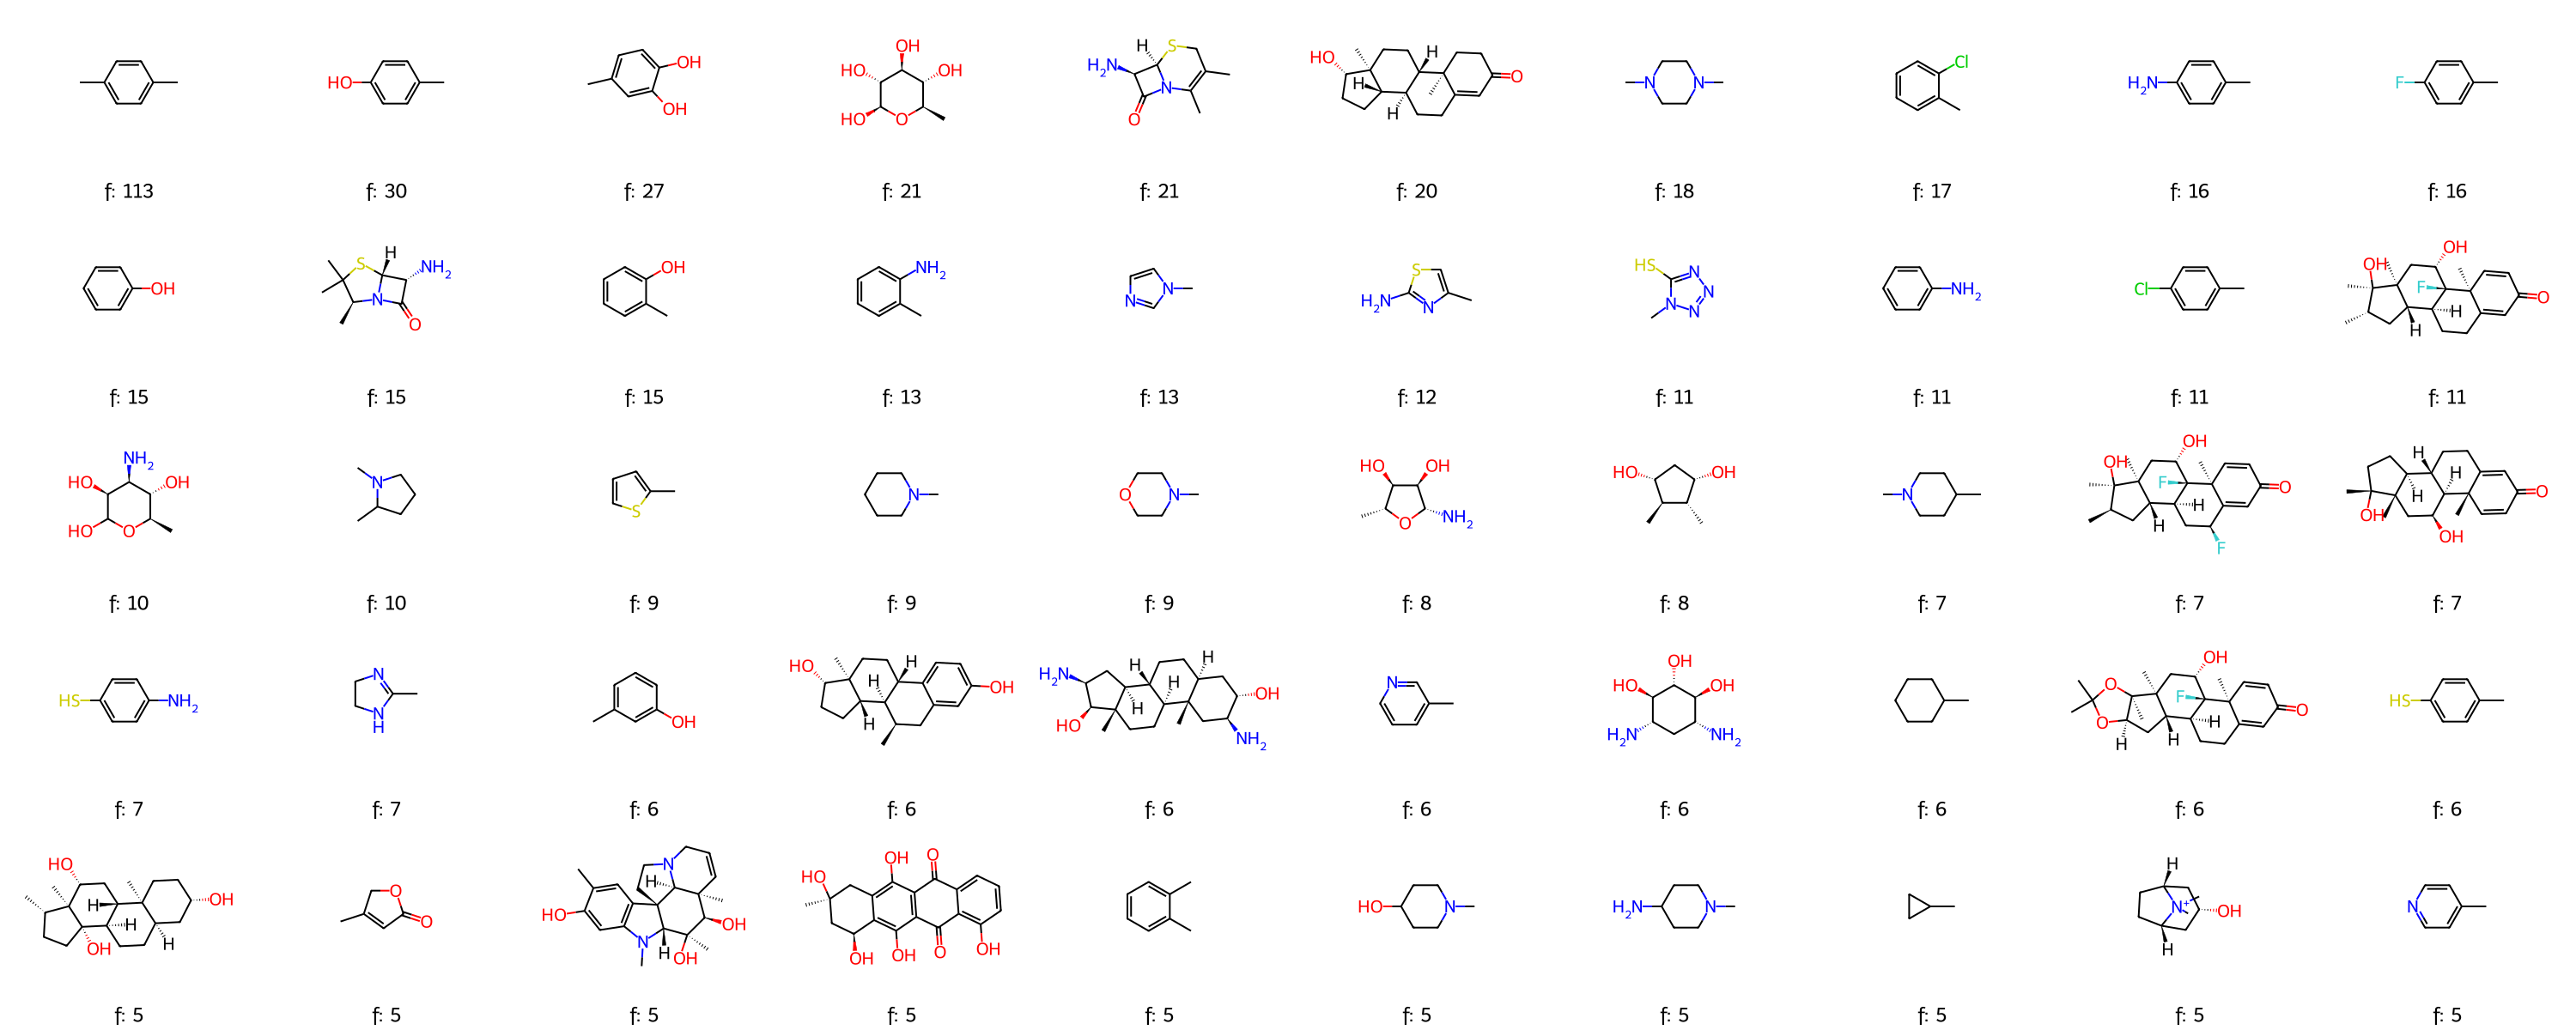

In [35]:
draw_top_n_centroids(100, non_oral_clusters, non_oral_rfs, molsPerRow=10)

In [36]:
non_oral_clusters_mcs_mols = get_clusters_mcs(clusters=non_oral_clusters[0:100], mols=non_oral_rfs)

# Getting the mol o fthefirst 100 oral_clusters centroids
non_oral_top_100_centroids = [cluster[0] for cluster in non_oral_clusters[0:100]]
non_oral_top_100_mol_centroids = [non_oral_rfs[i][0] for i in non_oral_top_100_centroids]
non_oral_legends_top_100_centroids = [f"n = {len(c)}" for c in non_oral_clusters[0:100]]

# Matches of the MCS
non_oral_cluster_mcs_and_centroids = zip(non_oral_clusters_mcs_mols, non_oral_top_100_mol_centroids, non_oral_legends_top_100_centroids)
non_oral_matches = []

for mcs, centroid, _ in non_oral_cluster_mcs_and_centroids:
    non_oral_matches.append(list(centroid.GetSubstructMatch(mcs)))

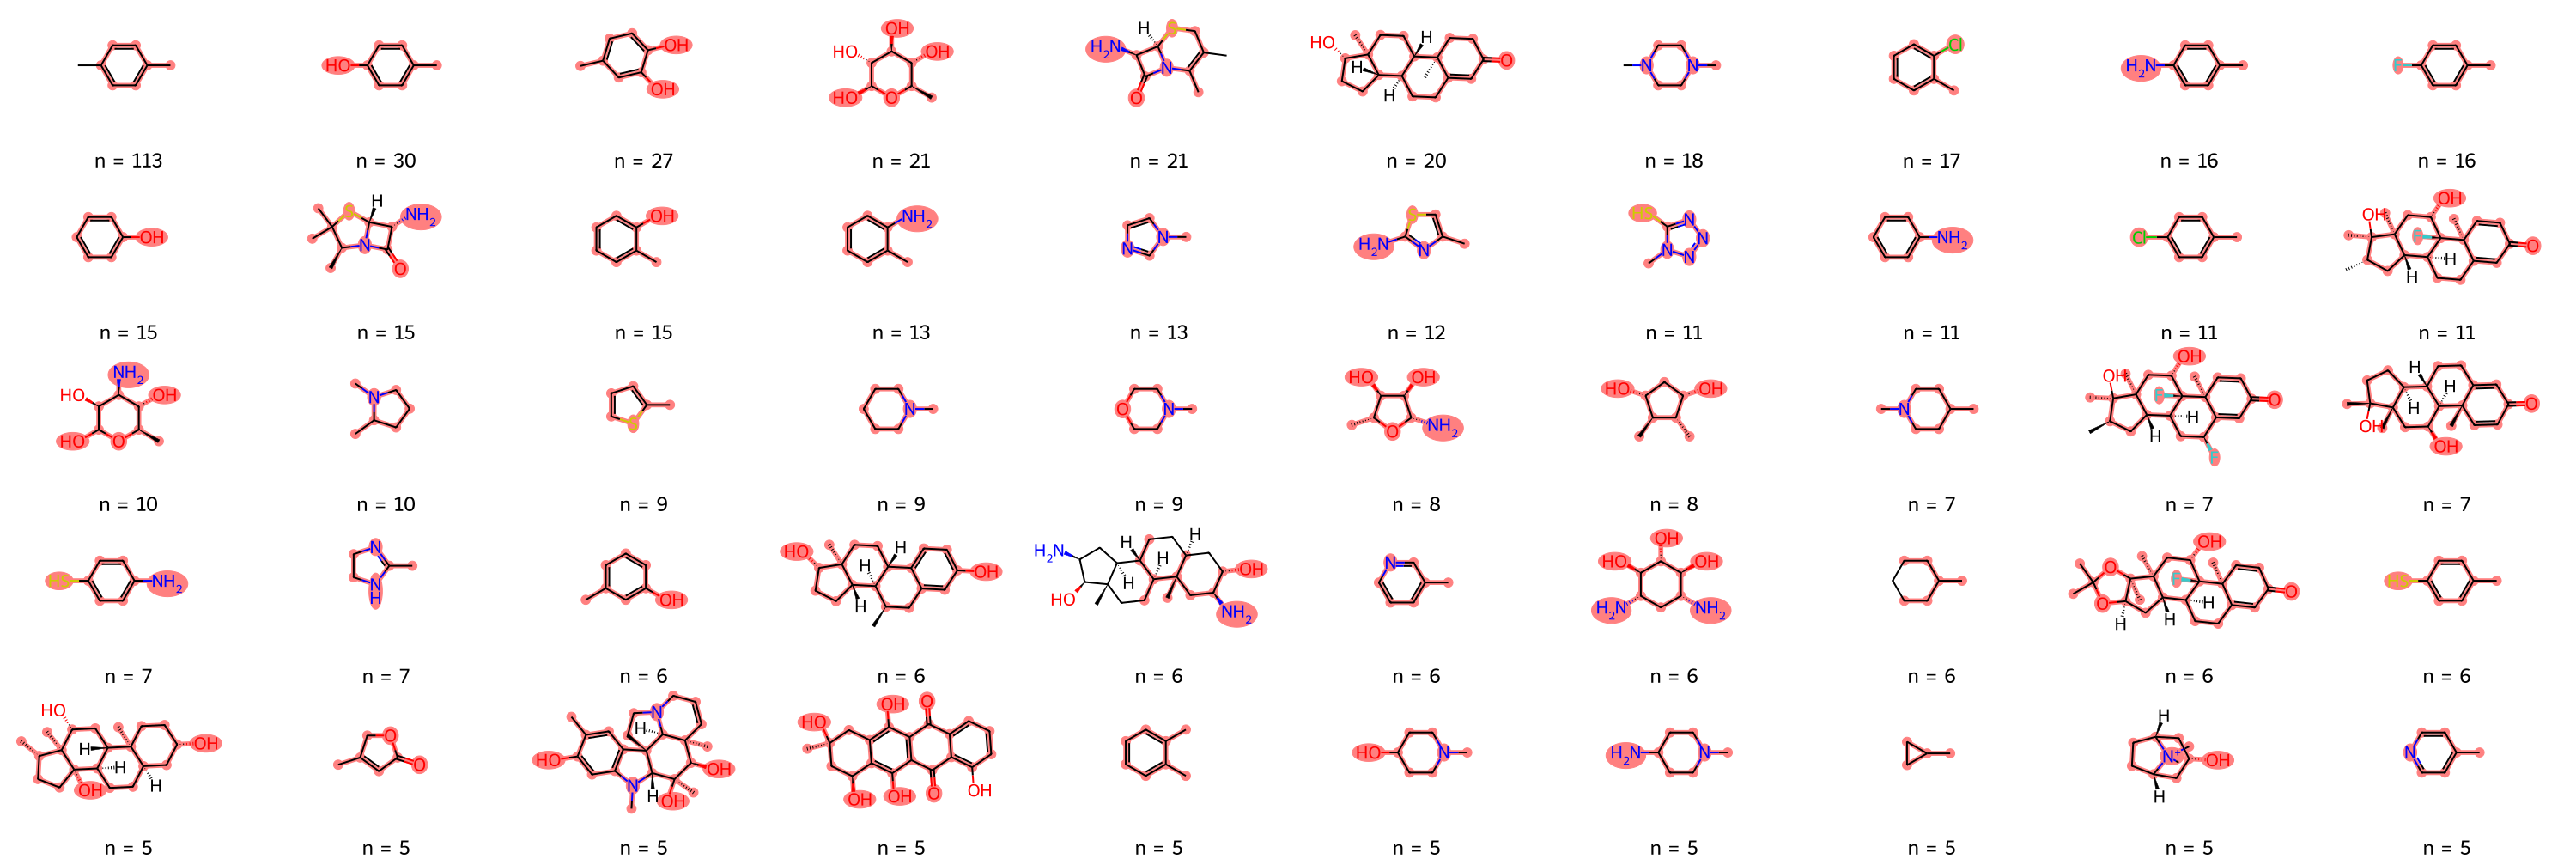

In [38]:
Draw.MolsToGridImage(
    non_oral_top_100_mol_centroids[0:50], 
    highlightAtomLists=non_oral_matches,
    legends=non_oral_legends_top_100_centroids[0:50],
    subImgSize=(300,200), 
    molsPerRow=10)

#### Grouped by Ring size